# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
# импорт необходимых библиотек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# чтение файла и запись в переменные
labels = pd.read_csv('dataset.csv')
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='...',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
# вывод общей информации о датафрейме
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
# вывод первых 5-ти строк
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [7]:
# вывод численного описания
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

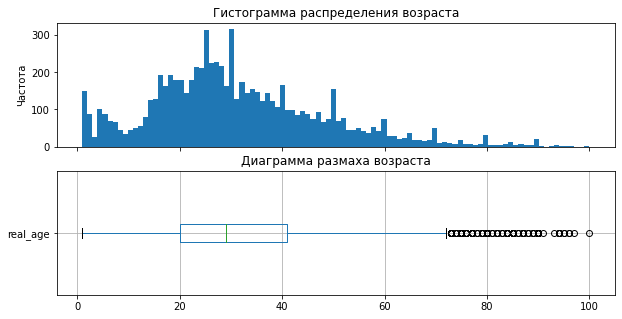

In [5]:
# построение гистограммы распределения и диаграммы размаха
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

ax[0].hist(labels['real_age'], bins=100)
ax[0].set_title("Гистограмма распределения возраста")
ax[0].set_xticklabels('')
ax[0].set_ylabel('Частота')

labels.boxplot('real_age', vert=False)
ax[1].set_title("Диаграмма размаха возраста")
plt.show()

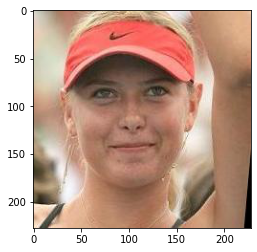

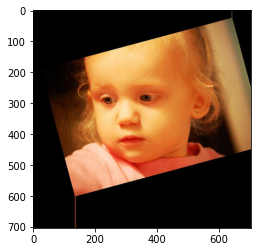

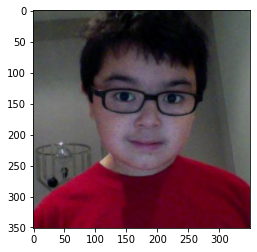

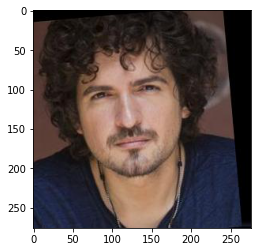

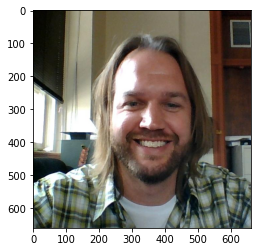

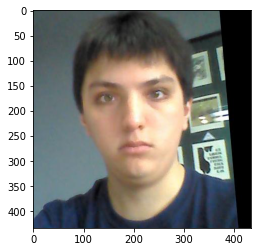

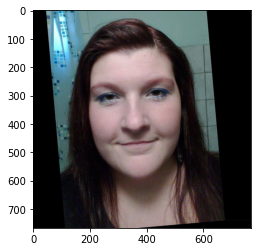

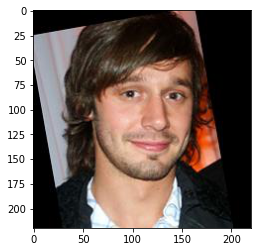

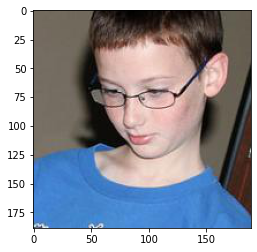

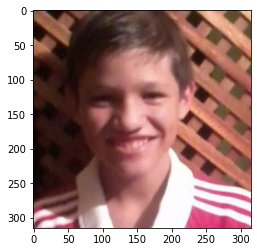

In [5]:
# вывод 10 случайных фотографий
for im in labels['file_name'].sample(10):
    image = mpimg.imread('/datasets/faces/final_files/'+im)
    plt.imshow(image)
    plt.show()

**ВЫВОД:**

1. Задача поставлена сетевым супермаркетом "Хлеб-Соль"
2. Данные взяты с сайта ChaLearn Looking at People и находятся в папке ...
3. Данные представлены в папке с изображениями ... и CSV-файлом dataset.csv
4. При загрузке данных был использован загрузчик ImageDataGenerator
5. Также при загрузке данных была использована аугментация
6. Полученный датафрейм имеет 7591 строку, без пропусков.
7. Гистограмма распределения мультимодальна, с большим хвостом справа.
8. Средний возраст (31,2) и медиана (29) имеют несущественное отличие.
9. Минимальный возраст в датафрейме - 1 год, максимальны - 100 лет.
10. На диаграмме размаха наблюдения выше примерно 72 лет находятся за пределами основного числа наблюдений.
11. Особенности данных по фото:
     - фотографии цветные
     - фото разного размера
     - на фото посторонние предметы
     - на фото лица крупным планом
     - развороты лица фас, анфас
12. Рекомендованы аугментации: вертикальный и горизонтальный повороты.

## Обучение модели

```python

import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.)

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


```

```

Train for 475 steps, validate for 119 steps
Epoch 1/20
2025-05-31 17:27:37.088714: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-05-31 17:27:37.418412: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
475/475 - 79s - loss: 221.0139 - mae: 11.3360 - val_loss: 412.0851 - val_mae: 15.4488
Epoch 2/20
475/475 - 49s - loss: 159.2683 - mae: 9.6818 - val_loss: 249.9476 - val_mae: 12.3695
Epoch 3/20
475/475 - 49s - loss: 138.3519 - mae: 9.0350 - val_loss: 145.7227 - val_mae: 9.2456
Epoch 4/20
475/475 - 49s - loss: 125.6565 - mae: 8.5684 - val_loss: 99.6629 - val_mae: 7.8096
Epoch 5/20
475/475 - 49s - loss: 119.0861 - mae: 8.3129 - val_loss: 114.9694 - val_mae: 8.1437
Epoch 6/20
475/475 - 49s - loss: 108.7449 - mae: 7.9634 - val_loss: 87.5512 - val_mae: 7.3137
Epoch 7/20
475/475 - 50s - loss: 102.4293 - mae: 7.7472 - val_loss: 231.5670 - val_mae: 11.1342
Epoch 8/20
475/475 - 50s - loss: 93.6863 - mae: 7.4058 - val_loss: 83.8656 - val_mae: 7.1313
Epoch 9/20
475/475 - 50s - loss: 86.3567 - mae: 7.1317 - val_loss: 177.5694 - val_mae: 9.8187
Epoch 10/20
475/475 - 49s - loss: 83.9949 - mae: 6.9551 - val_loss: 82.5696 - val_mae: 7.0145
Epoch 11/20
475/475 - 50s - loss: 77.0578 - mae: 6.6849 - val_loss: 82.3478 - val_mae: 6.9559
Epoch 12/20
475/475 - 50s - loss: 70.3764 - mae: 6.4587 - val_loss: 70.2449 - val_mae: 6.3772
Epoch 13/20
475/475 - 50s - loss: 68.7440 - mae: 6.3415 - val_loss: 108.6105 - val_mae: 7.7640
Epoch 14/20
475/475 - 50s - loss: 62.5077 - mae: 6.0553 - val_loss: 93.5766 - val_mae: 7.2897
Epoch 15/20
475/475 - 50s - loss: 56.7364 - mae: 5.7650 - val_loss: 94.8300 - val_mae: 7.3800
Epoch 16/20
475/475 - 49s - loss: 52.8908 - mae: 5.5726 - val_loss: 94.8715 - val_mae: 7.2475
Epoch 17/20
475/475 - 49s - loss: 49.0699 - mae: 5.3812 - val_loss: 91.6706 - val_mae: 7.3934
Epoch 18/20
475/475 - 49s - loss: 44.3829 - mae: 5.1371 - val_loss: 58.1694 - val_mae: 6.0257
Epoch 19/20
475/475 - 51s - loss: 41.7112 - mae: 4.9854 - val_loss: 82.8221 - val_mae: 6.8091
Epoch 20/20
475/475 - 50s - loss: 42.9085 - mae: 5.0193 - val_loss: 80.5413 - val_mae: 6.7540

```

## Анализ обученной модели

**Вывод:**

1. Задача поставлена сетевым супермаркетом "Хлеб-Соль"
2. Данные взяты с сайта ChaLearn Looking at People и находятся в папке /datasets/faces/
3. Данные представлены в папке с изображениями /final_files и CSV-файлом labels.csv
4. При загрузке данных был использован загрузчик ImageDataGenerator
5. Также при загрузке данных была использована аугментация: вертикальный и горизонтальный повороты.
6. Для создания модели была использована предобученная модель архитектуры ResNet50
7. Параметры при обучении модели:
    - количество эпох - 20,
    - оптимизатор - Adam()
7. При обучении модели было достигнуто значение метрики MAE 6,754 на тестовой выборке